This notebook collects the scripts used in the analysis of the A$_4$ tetranucleotide trajectories reported in

Pinamonti, G., Zhao, J., Condon, D.E., Paul, F., Noe, F., Turner, D.H., Bussi, G., (2016) "Studying the\
 kinetic properties of RNA oligonucleotides with Markov state models", submitted

Please cite us if using this data or any of these analysis tools.


Input MD data can be downloaded from
https://drive.google.com/open?id=0B5ljL0_IChrSSlFqUlZYelVuLWc

In [1]:
# Useful stuff
import sys
import cPickle as pickle
import time
import numpy as np

# PyEmma
import pyemma
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mpl

# plot
import matplotlib.pylab as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
%matplotlib inline

# my scripts
import my_tools as my
import readwrite as rw
import gvec_func as gv
import pvec_func as pv
import dihedrals_func as dih

# 1 - Input data definition and discretization

In [4]:
# input files definitions
directo='MD-data/tetro/'
trajfiles=[]
for idir in ['aform','n.syn','s.anti','s.syn']:
    trajfiles.append(directo+idir+'/all-strip.netcdf')
topfile=directo+'/topol.pdb'

In [5]:
feat_dGP=coor.featurizer(topfile)
nres=4
feat_dGP.add_custom_func(gv.get_gvecs,4*nres*nres)

top=feat_dGP.topology
lista_dihedrals=dih.get_dihedrals_ndx(top)
for ll in lista_dihedrals:
    feat_dGP.add_dihedrals(ll,cossin=True)
lista_pucker=dih.get_pucker_ndx(top)
for ll in lista_pucker:
    feat_dGP.add_dihedrals(ll,cossin=True)
lista_chis=dih.get_chi_ndx(top)
feat_dGP.add_dihedrals(lista_chis,cossin=True)

inp_dGP = coor.source(trajfiles, feat_dGP)

Obtaining file info: 100% (4/4) [##################################] eta 00:01 |

In [6]:
# Files for output structures
featXout=coor.featurizer(topfile)
featXout.add_all()
inpXout = coor.source(trajfiles, featXout)

Obtaining file info: 100% (4/4) [##################################] eta 00:01 |

In [7]:
print 'N. trajectories =',inp_dGP.ntraj
print 'N. frames =',inp_dGP.n_frames_total()
print 'Total length =',inp_dGP.n_frames_total()/10000., 'microseconds'

N. trajectories = 4
N. frames = 351314
Total length = 35.1314 microseconds


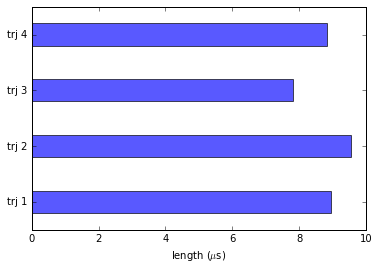

In [35]:
ppp=plt.barh(np.arange(0.3,len(inp_dGP.trajectory_lengths())),\
             inp_dGP.trajectory_lengths()/10000.,height=0.4,alpha=0.65)
plt.yticks(np.arange(0.5,4),['trj %d'%i for i in range(1,5)])
plt.xlabel(r'length ($\mu$s)')

## 1.1 - TICA analysis:

In [36]:
%time traj=coor.load(trajfiles,feat_dGP,chunk_size=1000)

getting output of FeatureReader: 100% (354/354) [##################] eta 00:01 -CPU times: user 4min 39s, sys: 1.15 s, total: 4min 40s
Wall time: 4min 48s


In [56]:
tica_obj=coor.tica(traj,50)
tica_traj=tica_obj.get_output()
tica_dim,cumvar=my.get_tica_cumvar(tica_obj)
print 'dimension=%d,%d' %(tica_dim,tica_obj.dimension())
### to read/write on disk
#rw.write_tica_eval('dG_lt50',tica_obj)
#rw.write_tica_evec('dG_lt50',tica_obj)
#rw.write_tica_trajs('dG_lt50',tica_traj)
#tica_dim=44
#tica_traj=rw.read_tica_trajs('tetro_lt50',4)
#tiva_eval=rw.read_tica_eval('tetro_lt50')
#tiva_evec=rw.read_tica_evec('tetro_lt50')
#print 'TICA dimension (n. of eigenvectors considered) =',tica_dim

getting output of TICA: 100% (72/72) [#############################] eta 00:01 \dimension=44,44


##  1.2 - Clustering:

In [57]:
### Clustering with k-means
%time cl = coor.cluster_kmeans(data=[X[:,0:tica_dim] for X in tica_traj], \
                               k=400,stride=1,max_iter=50,fixed_seed=True)
dtrajs = cl.assign(stride=1)
cl_centers=cl.clustercenters
### if you want to store clustering results on disk use this
#rw.write_cl_dtrajs('tetro_lt50_k400',dtrajs)
#rw.write_cl_centers('tetro_lt50_k400',cl)
#rw.write_cl_indexes('tetro_lt50_k400',cl)

### and this to read
#dtrajs=rw.read_cl_dtrajs(dire+'dG_lt50_k400',4)
#cl_centers=rw.read_cl_centers(dire+'dG_lt50_k400')
#cl_indexes=rw.read_cl_indexes(dire+'dG_lt50_k400')

kmeans iterations:  24% (12/50) [########                          ] eta 13:53 \05-10-16 14:02:20 pyemma.coordinates.clustering.kmeans.KmeansClustering[5] INFO     Cluster centers converged after 13 steps.
kmeans iterations: 100% (50/50) [##################################] eta 13:31 -CPU times: user 6min 22s, sys: 480 ms, total: 6min 22s
Wall time: 6min 22s
getting output of KmeansClustering: 100% (72/72) [#################] eta 00:01 -

In [58]:
Ytot=tica_traj[0]
for i in range(1,len(tica_traj)):
    Ytot=np.concatenate((Ytot,tica_traj[i]))
ix=0
iy=1
z,x,y = np.histogram2d(Ytot[:,ix],Ytot[:,iy], bins=100)
F01 = -np.log(z)
extent01 = [x[0], x[-1], y[0], y[-1]]
ix=2
iy=1
z,x,y = np.histogram2d(Ytot[:,ix],Ytot[:,iy], bins=100)
F21 = -np.log(z)
del Ytot
extent21 = [x[0], x[-1], y[0], y[-1]]

/u/sbp/giopina/software/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log
/u/sbp/giopina/software/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log


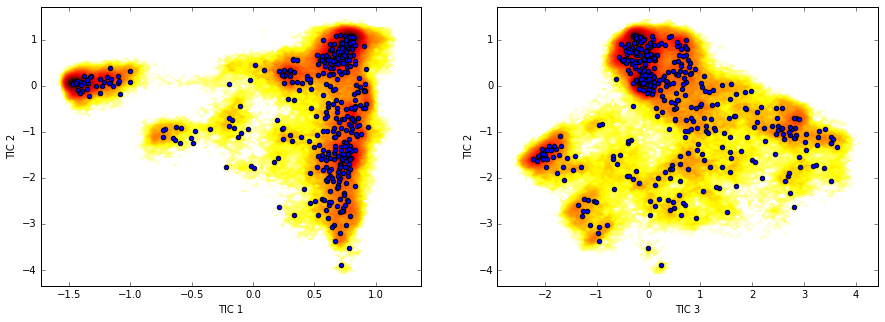

In [59]:
fig = plt.figure(figsize=(15,5))
plt.subplot2grid((1,2),(0,0))
ix=0
iy=1
plt.contourf(F01.T, 50, cmap=plt.cm.hot, extent=extent01)
plt.ylabel('TIC '+str(iy+1))
plt.xlabel('TIC '+str(ix+1))
plt.scatter(cl_centers[:,ix],cl_centers[:,iy])
plt.subplot2grid((1,2),(0,1))
ix=2
iy=1
plt.contourf(F21.T, 50, cmap=plt.cm.hot, extent=extent21)
plt.ylabel('TIC '+str(iy+1))
plt.xlabel('TIC '+str(ix+1))
plt.scatter(cl_centers[:,ix],cl_centers[:,iy])

# 2 - Markov state model construction and analysis

## 2.1 - Implied timescales:

In [60]:
### Implied timescales
its=msm.its(dtrajs,lags=[1,5,10,20,30,40,50,60,80,100,120,150,200,250,300,400],nits=15)

estimating MaximumLikelihoodMSM: 100% (16/16) [####################] eta 00:01 \

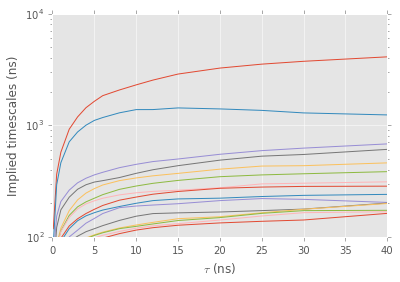

In [61]:
with plt.style.context(('ggplot')):    
    plt.plot(its.lags/10.,its.timescales[:,:25]/10.)
    plt.ylim(100,10000)
    plt.yscale('log')
    plt.ylabel('Implied timescales (ns)')
    plt.xlabel(r'$\tau$ (ns)')

## 2.2 - MSM construction and analysis: timescales and eigenvectors

In [62]:
M=msm.estimate_markov_model(dtrajs,200)
### read/write with
#rw.write_msm('tetro_lt50_k400_lm200',M)
#M=rw.read_msm('tetro_lt50_k400_lm200')

In [63]:
M.active_state_fraction

0.9975

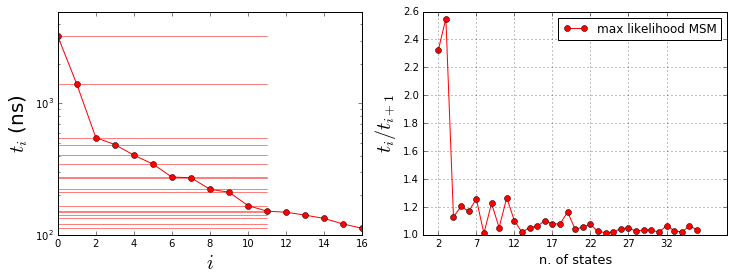

In [64]:
plt.figure(figsize=(12,4))
plt.subplot2grid((1,2),(0,0))
### Eigenvalues plot
plt.plot(M.timescales()[:17]/10,marker='o', color='red')
plt.plot([0,11],[80,80])
for ts in M.timescales()[:17]:
    plt.plot([0,11],[ts/10,ts/10],c='red',lw=0.5)
plt.yscale('log')
plt.ylim(100,5000)
plt.ylabel('$t_i$ (ns)',fontsize=20)
plt.xlabel('$i$',fontsize=20)
plt.subplot2grid((1,2),(0,1))

plt.plot(range(2,37),M.timescales()[0:35]/M.timescales()[1:36],\
         marker='o',color='red',label='max likelihood MSM')
plt.xlabel('n. of states',fontsize=13)
plt.ylabel('$t_i / t_{i+1}$',fontsize=20)
plt.grid()
plt.xticks(range(2,37,5))
plt.legend()

In [65]:
BM=msm.bayesian_markov_model(dtrajs,200,nsamples=500)
bm_timescales_mean=BM.sample_mean('timescales')
bm_timescales_std=BM.sample_std('timescales')
bm_timescales_conf=BM.sample_conf('timescales')

Sampling MSMs: 100% (500/500) [####################################] eta 00:01 |

In [66]:
print 'MSM timescales:'
for i in range(7):
    print('%4.f +- %4.f ns' % (M.timescales()[i]/10, bm_timescales_std[i]/10)  )

MSM timescales:
3250 +- 1321 ns
1399 +-  713 ns
 549 +-  379 ns
 486 +-  271 ns
 404 +-  128 ns
 346 +-   79 ns
 275 +-   52 ns


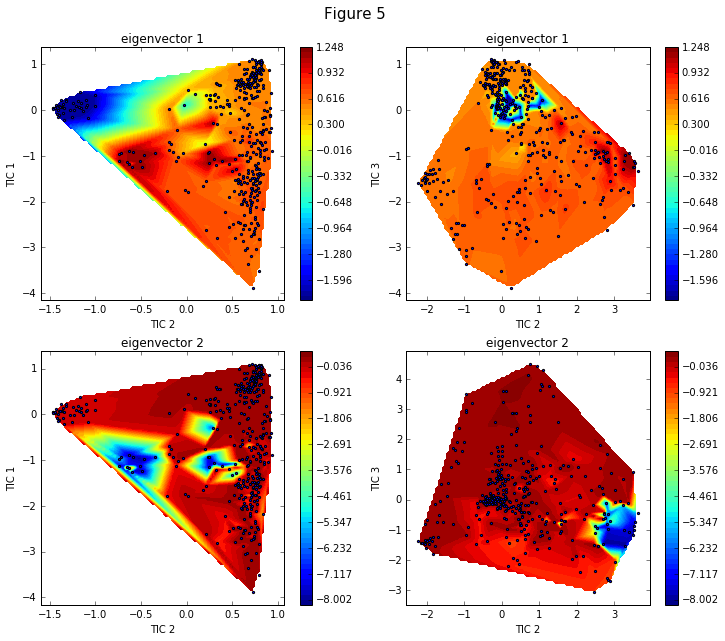

In [67]:
#cl_centers=cl.clustercenters
plt.figure(figsize=(12,10))
plt.subplot2grid((2,2),(0,0))
plt.text(1.5,2,'Figure 5',fontsize=15)
icomp=1
r2 = M.eigenvectors_right()[:,icomp]
mpl.scatter_contour(cl_centers[M.active_set,0], cl_centers[M.active_set,1], r2)
plt.title('eigenvector '+str(icomp))
plt.ylabel('TIC 1')
plt.xlabel('TIC 2')

plt.subplot2grid((2,2),(0,1))
icomp=1
r2 = M.eigenvectors_right()[:,icomp]
mpl.scatter_contour(cl_centers[M.active_set,2], cl_centers[M.active_set,1], r2)
plt.title('eigenvector '+str(icomp))
plt.ylabel('TIC 3')
plt.xlabel('TIC 2')

plt.subplot2grid((2,2),(1,0))
icomp=2
r2 = M.eigenvectors_right()[:,icomp]
mpl.scatter_contour(cl_centers[M.active_set,0], cl_centers[M.active_set,1], r2)
plt.title('eigenvector '+str(icomp))
plt.ylabel('TIC 1')
plt.xlabel('TIC 2')

plt.subplot2grid((2,2),(1,1))
icomp=2
r2 = M.eigenvectors_right()[:,icomp]
mpl.scatter_contour(cl_centers[M.active_set,2], cl_centers[M.active_set,3], r2)
plt.title('eigenvector '+str(icomp))
plt.ylabel('TIC 3')
plt.xlabel('TIC 2')

## 2.3 - Coarse graining the MSM with an hidden Markov model

In [73]:
nstates=4
HMM4=M.coarse_grain(nstates)
###
#rw.write_hmm('tetro_lt50_k400_lm200',HMM4)

05-10-16 14:15:05 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[6] WARNING  Requested coarse-grained model with 4 metastable states at lag=200.The ratio of relaxation timescales between 4 and 5 states is only 1.12861959755 while we recommend at least 1.5.  It is possible that the resulting HMM is inaccurate. Handle with caution.


In [74]:
BHMM4=msm.bayesian_hidden_markov_model(dtrajs,nstates,200,nsamples=500)
bhmm_timescales_std=BHMM4.sample_std('timescales')

Sampling HMSMs: 100% (500/500) [###################################] eta 00:01 -

In [75]:
print 'MSM timescales:'
for i in range(nstates-1):
        print('%4.f ns \t %4.f +- %4.f ns\t' % \
              (M.timescales()[i]/10,HMM4.timescales()[i]/10,bhmm_timescales_std[i]/10))

MSM timescales:
3250 ns 	 4677 +- 4080 ns	
1399 ns 	  746 +-  204 ns	
 549 ns 	  442 +-  107 ns	


In [76]:
HMM4.timescales()/10

array([ 4677.39918129,   746.44643407,   441.91510232])

In [77]:
bhmm_statdist_mean=BHMM4.sample_mean('stationary_distribution')
bhmm_statdist_std=BHMM4.sample_std('stationary_distribution')
for ii in range(nstates):
    print '%2.f (%2.f) +- %2.f'%\
    (HMM4.stationary_distribution[ii]*100,\
     bhmm_statdist_mean[ii]*100,\
     bhmm_statdist_std[ii]*100)

 7 ( 6) +-  5
21 (18) +-  9
53 (43) +- 15
19 (32) +- 20


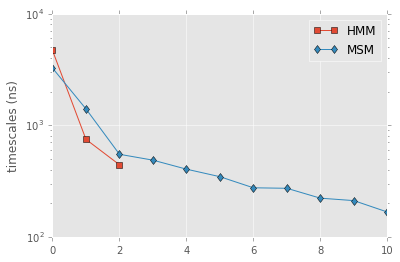

In [80]:
with plt.style.context(('ggplot')):
    plt.plot(HMM4.timescales()/10,marker='s',label='HMM')
    plt.plot(M.timescales()[:11]/10,marker='d',label='MSM')
    plt.yscale('log')
    plt.ylabel('timescales (ns)')
    plt.legend()

In [17]:
%time hmm4_its=msm.timescales_hmsm(dtrajs,4,lags=[1,10,50,100,150,200,300,400])

estimating MaximumLikelihoodHMSM: 100% (8/8) [#####################] eta 00:00 /CPU times: user 32min 44s, sys: 55.3 s, total: 33min 39s
Wall time: 15min 12s


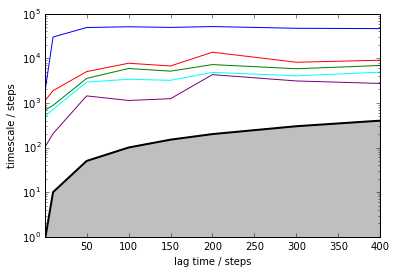

In [18]:
mpl.plot_implied_timescales(hmm4_its)

In [81]:
def plot_hmm(hmm_obj,ix=0,iy=1):
    colors=np.array(['blue','red','green','darkturquoise'])
    Ytot=tica_traj[0]
    for i in range(1,len(tica_traj)):
        Ytot=np.concatenate((Ytot,tica_traj[i]))
    z,x,y = np.histogram2d(Ytot[:,ix],Ytot[:,iy], bins=100)
    F = -np.log(z)
    del Ytot
    extent = [x[0], x[-1], y[0], y[-1]]
    pcca_sets = hmm_obj.metastable_sets
    plt.contourf(F.T, 50, cmap=plt.cm.Greys_r, extent=extent)
    for ipcca in range(len(pcca_sets)):
        plt.scatter(cl_centers[pcca_sets[ipcca],ix], cl_centers[pcca_sets[ipcca],iy]\
                , color=colors[ipcca%len(colors)],label='set '+str(ipcca),alpha=0.7)
    plt.ylabel('TICA '+str(iy+1))
    plt.xlabel('TICA '+str(ix+1))

/u/sbp/giopina/software/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log


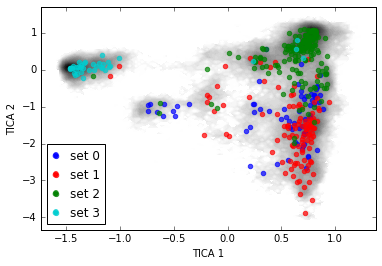

In [82]:
plot_hmm(HMM4)
plt.legend(numpoints=1,handlelength=0.7,loc=3)

In [83]:
hmm_obj=HMM4
nstates=hmm_obj.nstates
states_pos=np.array([\
            np.sum(cl_centers[hmm_obj.observable_set,:2]*\
                   hmm_obj.metastable_distributions[istate][:,np.newaxis],axis=0)\
            for istate in range(nstates)])

In [85]:
from scipy.linalg import logm
hmm_rate_matrix=logm(HMM4.transition_matrix)
hmm_rate_matrix2=hmm_rate_matrix/HMM4.lagtime*10*1000 #rates in \mu s^-1
hmm_rate_matrix2[np.abs(hmm_rate_matrix2)<1e-02]=0.0

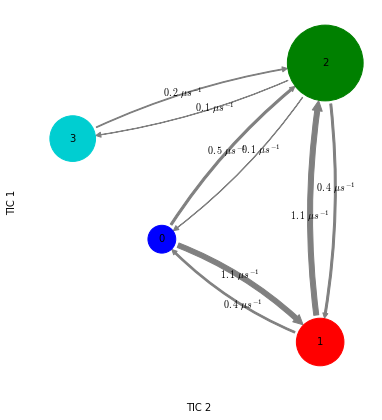

In [86]:
my_pos=np.array(states_pos)
my_pos[0]+=np.array([-1.1,0.35])
#my_pos[1]+=np.array([0,-2])
fff=mpl.plot_network(hmm_rate_matrix2,state_colors=colors,\
                     state_sizes=HMM4.stationary_distribution,\
                     pos=my_pos,\
                     arrow_label_format=r'$%2.1f$ $\mu s^{-1}$',\
                     max_width=7,max_height=7)
plt.ylabel('TIC 1')
plt.xlabel('TIC 2')

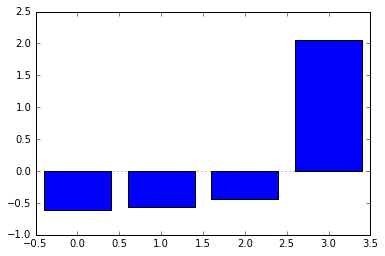

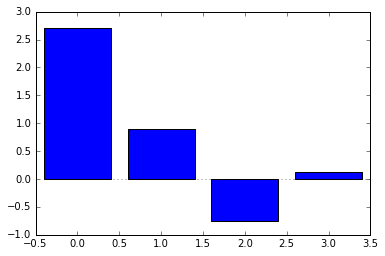

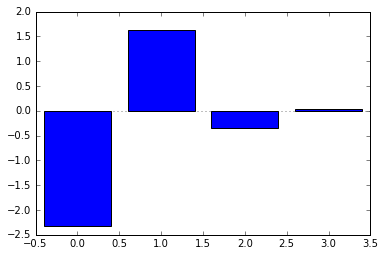

In [87]:
for icomp in range(1,nstates):
    plt.figure()
    plt.bar(np.array(range(nstates))-0.4,hmm_obj.eigenvectors_right()[:,icomp])
    plt.plot([0,4],[0,0],color='black',lw=1,ls=':',alpha=0.5)
    plt.xlim(-0.5,3.5)

# 3 -HMM's metastable states analysis

In [89]:
hmm_obj=HMM4
hmm_dist = hmm_obj.metastable_distributions
hmm_samples = M.sample_by_distributions(hmm_dist, 1000)
outfiles = ['trino_hmm'+str(i)+'_'+str(nstates)+'ms_1000states.xtc' for i in range(0,nstates)]
coor.save_trajs(inpXout, hmm_samples, outfiles=outfiles)

['trino_hmm0_4ms_1000states.xtc',
 'trino_hmm1_4ms_1000states.xtc',
 'trino_hmm2_4ms_1000states.xtc',
 'trino_hmm3_4ms_1000states.xtc']

## Stacked percentages

In [90]:
nstates=hmm_obj.nstates
import stackdef as stack
feat_stack=coor.featurizer(topfile)
for i in range(4):
    for j in range(i+1,4):
        print 'stacking between:',i,j
        feat_stack.add_custom_func(stack.get_stack_score,1,i,j)

print 'N. of features:',feat_stack.dimension()
### cmomputing observables
stack_meta_states=np.array(coor.load(outfiles,feat_stack,chunk_size=1000))

stacking between: 0 1
stacking between: 0 2
stacking between: 0 3
stacking between: 1 2
stacking between: 1 3
stacking between: 2 3
N. of features: 6
getting output of FeatureReader: 100% (4/4) [######################] eta 00:00 -

In [107]:
#print stack_meta_states
stack_percentages=[]
for istate in range(nstates):
    tmp_stack=[]
    for kres in range(6):
        print len(np.where(stack_meta_states[istate][:,kres]>1.)[0])/10.,
        tmp_stack.append(len(np.where(stack_meta_states[istate][:,kres]>1.)[0])/10.)
    stack_percentages.append(np.array(tmp_stack))
    print ''
stack_percentages=np.array(stack_percentages)

7.7 18.9 4.5 1.4 35.8 9.2 
9.4 5.7 6.3 11.0 10.5 32.1 
14.2 0.2 5.0 25.1 5.0 19.3 
0.1 98.2 64.8 58.5 0.0 0.0 


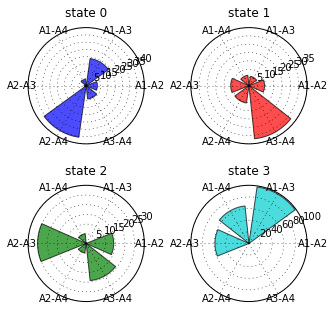

In [108]:
f,axs = plt.subplots(2,2,subplot_kw=dict(projection='polar'),figsize=(5,5))
f.subplots_adjust(hspace=0.3,wspace=0.4)
for istate in range(nstates):
    ax=axs[istate/2,istate%2]
    ax.bar([(x-0.4)*np.pi/3 for x in range(6)],stack_percentages[istate],\
           label='state '+str(istate),color=colors[istate],alpha=0.7)
    temp=ax.set_xticks([x*2*np.pi/6 for x in range(6)])
    labs=[]
    for ires in range(4):
        for jres in range(ires+1,4):
            labs.append('A%s-A%s' % (ires+1,jres+1))
    temp=ax.set_xticklabels(labs)#,rotation=60)
    ax.set_title('state '+str(istate),fontsize=12)

# Dihedrals (alpha, zeta)

In [93]:
feat_dih=coor.featurizer(topfile)
top=feat_dih.topology
lista_dihedrals=dih.get_dihedrals_ndx(top)
for ll in lista_dihedrals:
    feat_dih.add_dihedrals(ll,cossin=False)
lista_pucker=dih.get_pucker_ndx(top)
for ll in lista_pucker:
    feat_dih.add_dihedrals(ll,cossin=False)
lista_chis=dih.get_chi_ndx(top)
feat_dih.add_dihedrals(lista_chis,cossin=False)

In [94]:
dih_meta_states=np.array(coor.load(outfiles,feat_dih))

getting output of FeatureReader: 100% (4/4) [######################] eta 00:01 -

In [95]:
dih_names=[]
for lll,name in zip(lista_dihedrals,[r'$\alpha',r'$\beta',r'$\gamma',r'$\delta',r'$\epsilon',r'$\zeta']):
    for i in range(len(lll)):
        if name==r'$\alpha' or name==r'$\beta':
            dih_names.append(name+'_'+str(i+2)+'$')
        else:
            dih_names.append(name+'_'+str(i+1)+'$')
for lll,name in zip(lista_pucker,[r'$\nu^0',r'$\nu^1',r'$\nu^2',r'$\nu^3',r'$\nu^4']):
    for i in range(len(lll)):
        dih_names.append(name+'_'+str(i+1)+'$')
lll=lista_chis
name=r'$\chi'
for i in range(len(lll)):
    dih_names.append(name+'_'+str(i+1)+'$')
print len(dih_names), 'dihedrals'

44 dihedrals


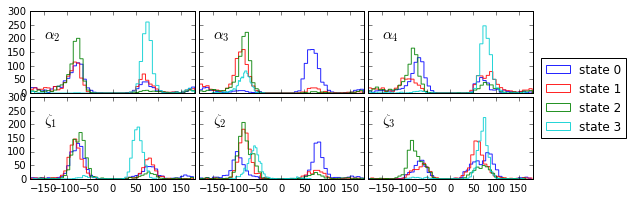

In [106]:
fig, axes = plt.subplots(2,3, \
        figsize=(9,3.),sharex=True,sharey=True)#,sharey=True,sharex=True)
plt.subplots_adjust(hspace=0.05,wspace=0.025)
iplot=0
for i_dih in[0,1,2]:
    ax=axes[0,iplot]
    ax.text(-150,200,dih_names[i_dih],fontsize=15)
    for istate in range(0,nstates):
        ax.hist(dih_meta_states[istate][:,i_dih]*180/np.pi,histtype='step',\
                lw=1.,bins=50,normed=False,\
                 label='state '+str(istate),color=colors[istate],alpha=0.85)
    iplot+=1
iplot=0
for i_dih in[17,18,19]:
    ax=axes[1,iplot]
    ax.text(-150,200,dih_names[i_dih],fontsize=15)
    for istate in range(0,nstates):
        ax.hist(dih_meta_states[istate][:,i_dih]*180/np.pi,histtype='step',\
                lw=1.,bins=50,normed=False,\
                 label='state '+str(istate),color=colors[istate],alpha=0.85)
    iplot+=1
    ax.set_xticks(range(-150,151,50))
plt.legend(loc=(1.05,0.5))

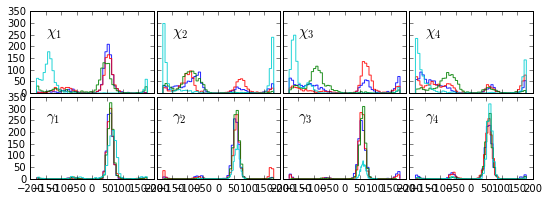

In [105]:
#8.27 in × 11.7
iplot=0
fig, axes = plt.subplots(2,4, \
        figsize=(9,3.),sharex=True,sharey=True)#,sharey=True,sharex=True)
plt.subplots_adjust(hspace=0.05,wspace=0.025)
for i_dih in range(40,44):
    ax=axes[0,iplot]
    ax.text(-150,250,dih_names[i_dih],fontsize=15)
    for istate in range(0,nstates):
        ax.hist(dih_meta_states[istate][:,i_dih]*180/np.pi,histtype='step',lw=1,bins=50,normed=False,\
                 label='state '+str(istate),color=colors[istate],alpha=0.85)
    iplot+=1
iplot=0
for i_dih in range(6,10):
    ax=axes[1,iplot]
    ax.text(-150,250,dih_names[i_dih],fontsize=15)
    for istate in range(0,nstates):
        ax.hist(dih_meta_states[istate][:,i_dih]*180/np.pi,histtype='step',lw=1,bins=50,normed=False,\
                 label='state '+str(istate),color=colors[istate],alpha=0.85)
    iplot+=1

In [99]:
# G-vectors
feat_G=coor.featurizer(topfile)
nres=4
feat_G.add_custom_func(gv.get_gvecs,4*nres*nres)
inp_G = coor.source(trajfiles, feat_G)
### cmomputing observables
gvec_meta_states=np.array(coor.load(outfiles,feat_G))
var_names=[]
### G-VECTORS
nres=4
for ires in range(nres):
    for jres in range(nres):
        for mu in ['x','y','z','t']:
            var_names.append('$(G_{'+str(ires+1)+' '+str(jres+1)+'})_'+mu+'$')    

getting output of FeatureReader: 100% (4/4) [######################] eta 00:01 -

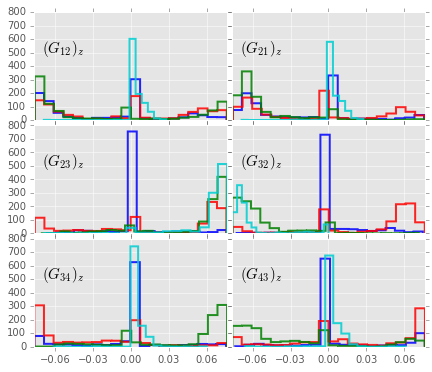

In [104]:
with plt.style.context(('ggplot')):
    fig, axes = plt.subplots(3,2, \
        figsize=(7,6),sharex=True,sharey=True)#,sharey=True,sharex=True)
    plt.subplots_adjust(hspace=0.05,wspace=0.025)
    kplt=0
    for kgkg in [[6,18],[26,38],[46,58]]:
        for k_gvec,iplt in zip(kgkg,[0,1]):
            ax=axes[kplt,iplt]
            for istate in range(nstates):            
                ax.hist(gvec_meta_states[istate][:,k_gvec],
                        bins=20,color=colors[istate],histtype='step',lw=2,\
                    label=str(istate),alpha=0.85)
            ax.text(-0.07,500,var_names[k_gvec],fontsize=15)
        kplt+=1
        ax.set_xticks(np.arange(-0.06,0.07,0.03))

# Kinetics of stacking

In [101]:
inp_stack=coor.source(trajfiles,feat_stack,chunk_size=500)
%time avg_stack_cl=my.average_by_state(M,inp_stack)

getting output of FeatureReader: 100% (705/705) [##################] eta 00:01 \CPU times: user 27min 14s, sys: 2.38 s, total: 27min 17s
Wall time: 27min 21s


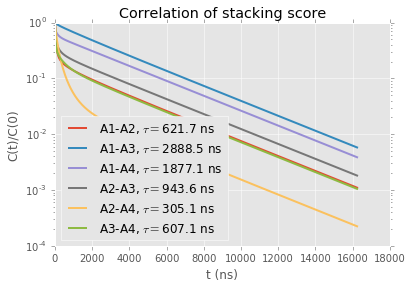

In [102]:
with plt.style.context(('ggplot')):
    kres=0
    for ires in range(4):
        for jres in range(ires+1,4):
            media_sq=np.dot(avg_stack_cl[:,kres],M.stationary_distribution)**2
            times,corr=M.correlation(avg_stack_cl[:,kres])
            acorr=(corr-media_sq)/(corr[0]-media_sq)
            t_corr=(0.5+np.sum(acorr[1:]))*M.lag/10
            plt.plot(times/10,acorr,label=r'A%d-A%d, $\tau=$%.1f ns'%(ires+1,jres+1,t_corr),\
                    lw=2)
            kres+=1
    plt.ylabel('C(t)/C(0)');plt.xlabel('t (ns)')
    plt.yscale('log')
    plt.legend(loc=3)
    plt.title('Correlation of stacking score')

In [109]:
evec_idx=np.arange(3,M.nstates)
roba=np.tensordot(M.eigenvectors_left()[evec_idx,:],avg_stack_cl,axes=[1,0])
tau_a=np.sum( (roba**2)*M.timescales()[evec_idx-1,np.newaxis] ,axis=0)\
/np.sum(roba**2,axis=0)
print '\nStacking autocorrelation times:\n'
print 'A1-A2 = %2.1f ns' % (tau_a[0]/10.)
print 'A1-A3 = %2.1f ns' % (tau_a[1]/10.)
print 'A1-A4 = %2.1f ns' % (tau_a[2]/10.)
print 'A2-A3 = %2.1f ns' % (tau_a[3]/10.)
print 'A2-A4 = %2.1f ns' % (tau_a[4]/10.)
print 'A3-A4 = %2.1f ns' % (tau_a[5]/10.)


Stacking autocorrelation times:

A1-A2 = 76.0 ns
A1-A3 = 167.4 ns
A1-A4 = 67.3 ns
A2-A3 = 82.6 ns
A2-A4 = 187.4 ns
A3-A4 = 86.8 ns
